# COVID-19 Visualizations

This notebook provides some basic visuals on the COVID-19 coronavirus. Data is from the European Centre for Disease Prevention and Control.

-----------------------------

# Table of Contents
- [Import Modules](#import)
- [Setup](#setup)
- [Scrape & Download](#scrape)
- [Load Data](#load)
- [Visualizations](#viz)

# Import Modules <div id='import'/>

In [1]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
import os
import configparser
import re
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
import matplotlib.dates as dates
import datetime

# Setup <div id='setup'/>

In [2]:
# Bind directory references
REPO_DIR  = "/repos/covid19"
DATA_DIR  = REPO_DIR + "/data"
SOURCE_DIR = REPO_DIR + "/source"
CONFIG_DIR = REPO_DIR + "/config"

# import functions from helpers.py
os.chdir(SOURCE_DIR)
from helpers import dir_df, from_url, scrape_link
os.chdir(REPO_DIR)

# dataframe display setup
pd.set_option('display.max_columns', None)
%matplotlib inline
mplstyle.use('fivethirtyeight')

# parse config file to get url of ECDC website (having a config file is overkill for this but it is what it is)
config = configparser.ConfigParser()
config.read(CONFIG_DIR+"/covid19.cfg")
url = config['specs']['Webpage']

# Scrape & Download <div id='scrape'/>

In [3]:
# scrape download link from the ECDC website
url_down = scrape_link(url, ".xls")

# confirm that only one link is coming through
assert len(url_down)==1, "Scrape returned links to more than one .xls file"

# links come through as a list so we are taking the first
url_down = url_down[0]

# parsing the data out of the file
dt = re.findall("2020......",url_down)[0].replace("-","_",2)

# downloading the file and saving it down to the repo
from_url(url=url_down,dest=DATA_DIR+"/"+dt+"_covid19.xls")

'File downloaded to the following location: /repos/covid19/data/2020_03_16_covid19.xls'

# Load Data <div id='load'/>

In [4]:
# compile dataframe of all data files available - usually 1 per day
file_df = dir_df(DATA_DIR)
file_df['FILE_DATE'] = file_df.FILE_NAME.str[0:10]
file_df = file_df.sort_values(by='FILE_DATE', ascending=False).reset_index(drop = True)
file_df

,FILE_NAME,FILE_PATH,FILE_SIZE,FILE_DATE
0,2020_03_16_covid19.xls,/repos/covid19/data/2020_03_16_covid19.xls,616960,2020_03_16
1,2020_03_15_covid19.xls,/repos/covid19/data/2020_03_15_covid19.xls,602624,2020_03_15
2,2020_03_14_covid19.xls,/repos/covid19/data/2020_03_14_covid19.xls,586752,2020_03_14
3,2020_03_13_covid19.xls,/repos/covid19/data/2020_03_13_covid19.xls,577536,2020_03_13
4,2020_03_12_covid19.xls,/repos/covid19/data/2020_03_12_covid19.xls,567808,2020_03_12


In [5]:
# Read top file & rename columns (lord knows what Gaul1Nuts1 means)
df = pd.read_excel(file_df['FILE_PATH'][0], 
                   names=["DATE_REP","COUNTRY_NAME",
                          "NEW_CASES","NEW_DEATHS",
                          "COUNTRY_ABR","GAUL1NUTS1","EU"])
# Data cleanup
df['AS_OF_DATE'] = pd.to_datetime(file_df['FILE_DATE'][0],
                                  format="%Y_%m_%d")

In [6]:
# Let's view our dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5250 entries, 0 to 5249
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   DATE_REP      5250 non-null   datetime64[ns]
 1   COUNTRY_NAME  5250 non-null   object        
 2   NEW_CASES     5250 non-null   int64         
 3   NEW_DEATHS    5249 non-null   float64       
 4   COUNTRY_ABR   5248 non-null   object        
 5   GAUL1NUTS1    509 non-null    object        
 6   EU            5250 non-null   object        
 7   AS_OF_DATE    5250 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 328.2+ KB


In [7]:
### Let's check out the top 5 rows of our dataframe
df.head()

,DATE_REP,COUNTRY_NAME,NEW_CASES,NEW_DEATHS,COUNTRY_ABR,GAUL1NUTS1,EU,AS_OF_DATE
0,2020-03-16,Afghanistan,6,0.0,AF,NaN,Non-EU/EEA,2020-03-16
1,2020-03-15,Afghanistan,3,0.0,AF,NaN,Non-EU/EEA,2020-03-16
2,2020-03-11,Afghanistan,3,0.0,AF,NaN,Non-EU/EEA,2020-03-16
3,2020-03-08,Afghanistan,3,0.0,AF,NaN,Non-EU/EEA,2020-03-16
4,2020-03-02,Afghanistan,0,0.0,AF,NaN,Non-EU/EEA,2020-03-16


# Visualizations <div id='viz'/>

## 1. Prep Data

### Worldwide Cases & Deaths

In [8]:
# summarize data and cut out a few weeks of negligible cases 
wc = df.groupby(['DATE_REP'])[['NEW_CASES','NEW_DEATHS']].sum().reset_index()
wc = wc[wc['DATE_REP'] > datetime.datetime(2020,1,15)]

### EU vs Non-EU Cases

In [9]:
eu = df

# clean up values in the column
eu.loc[eu['EU'] == 'EU', 'EU'] = 'EU'  
eu.loc[eu['EU'] != 'EU', 'EU'] = 'Non-EU'

# summarize data and cut out a few weeks of negligible cases 
eu = eu.groupby(['DATE_REP','EU'])[['NEW_CASES']].sum().reset_index()
eu = eu[eu['DATE_REP'] >= datetime.datetime(2020,1,15)]

# stackplot needs a list of lists to plot y axis
eu_y = [np.array(eu[eu['EU']=="EU"]['NEW_CASES']),
        np.array(eu[eu['EU']!="EU"]['NEW_CASES'])]

#test lengths of case numbers
assert len(eu_y[0]) == len(eu_y[1]), "lists are of unequal length"

### US vs Italy

In [10]:
# split out two distinct datasets - one for US and one for Italy
df_us  = df[df['COUNTRY_NAME']=="United States of America"].reset_index(drop=True)
df_itl = df[df['COUNTRY_NAME']=="Italy"].reset_index(drop=True)

# filter down on dates
df_us  = df_us[df_us['DATE_REP'] >= datetime.datetime(2020,2,15)]
df_itl = df_itl[df_itl['DATE_REP'] >= datetime.datetime(2020,2,15)]

#test dfs are the same length
assert len(df_itl.index) == len(df_us.index), "dataframes are of unequal length"

## 2. Plot Data

### Worldwide Cases & Deaths

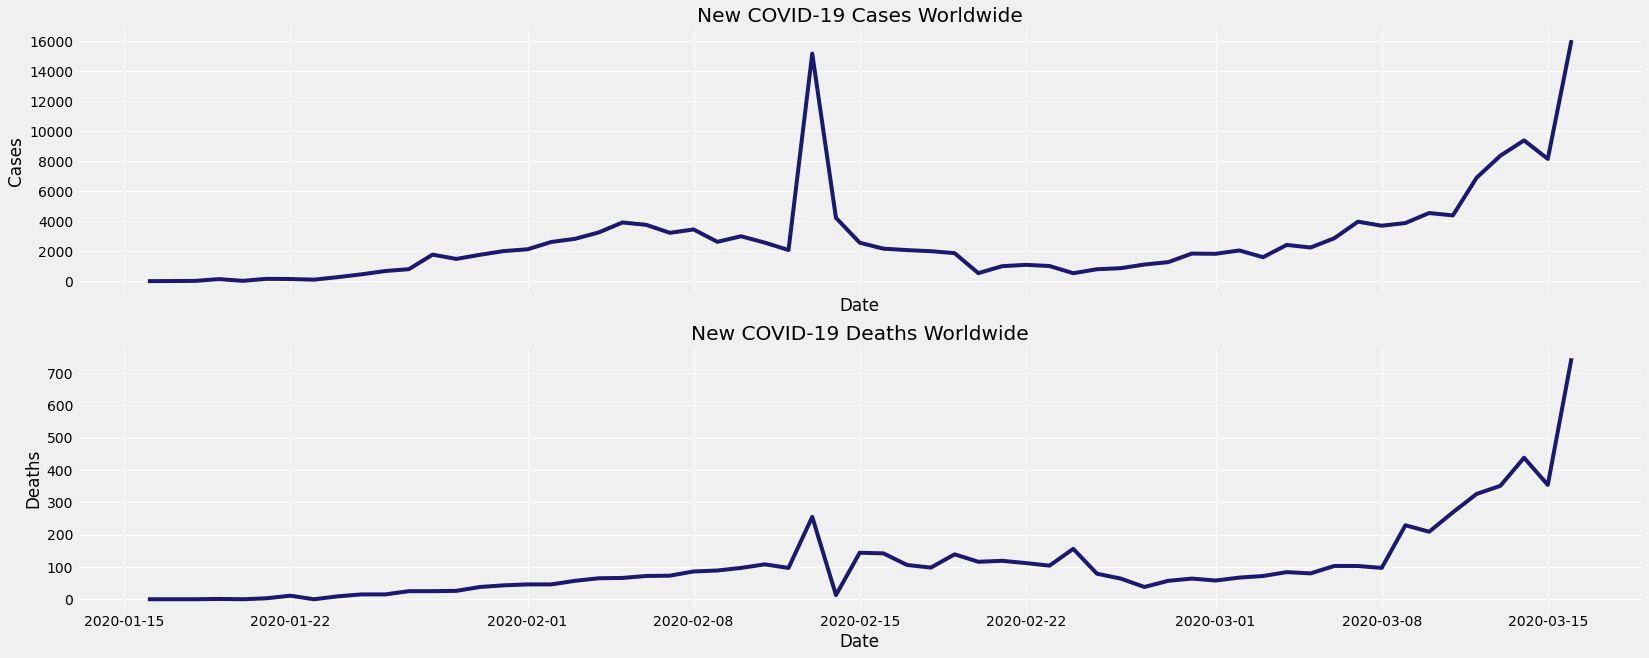

In [11]:
# plotting new cases by day worldwide
plt.rcParams['figure.figsize'] = [25, 10]
fig, ax = plt.subplots(2,sharex=True)
# top chart of cases
ax[0].plot(wc['DATE_REP'], wc['NEW_CASES'],color="midnightblue")
ax[0].set(xlabel='Date', ylabel='Cases',
       title='New COVID-19 Cases Worldwide')
ax[0].grid(color='white')

# bottom chart of deaths
ax[1].plot(wc['DATE_REP'], wc['NEW_DEATHS'],color="midnightblue")
ax[1].set(xlabel='Date', ylabel='Deaths',
       title='New COVID-19 Deaths Worldwide')
ax[1].grid(color='white')

### EU vs. Non-EU Cases

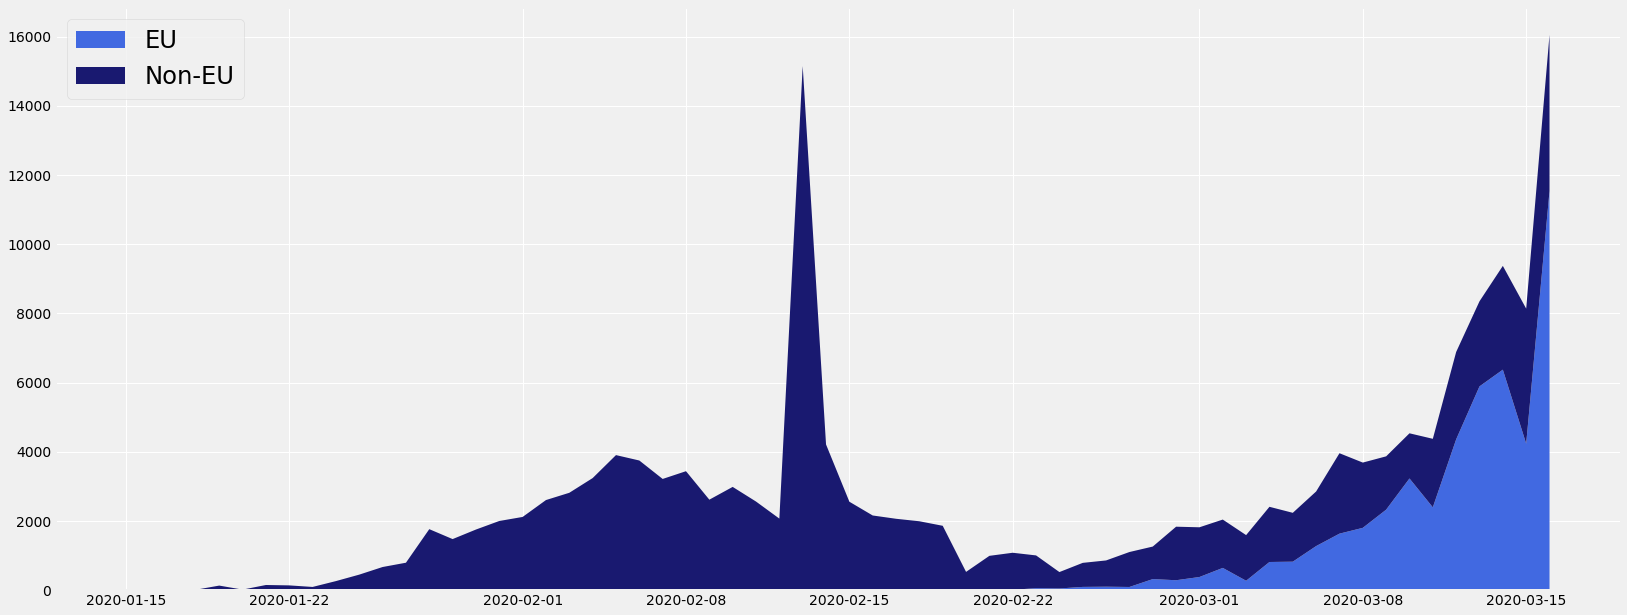

In [12]:
# plotting EU vs. Non-EU New Cases
fig, ax = plt.subplots()
ax.stackplot(eu['DATE_REP'].drop_duplicates(),eu_y,
             labels=['EU','Non-EU'],
             colors=["royalblue", "midnightblue"])
ax.legend(loc='upper left', fontsize = "xx-large")
ax.grid(color="white")

### US vs. Italy

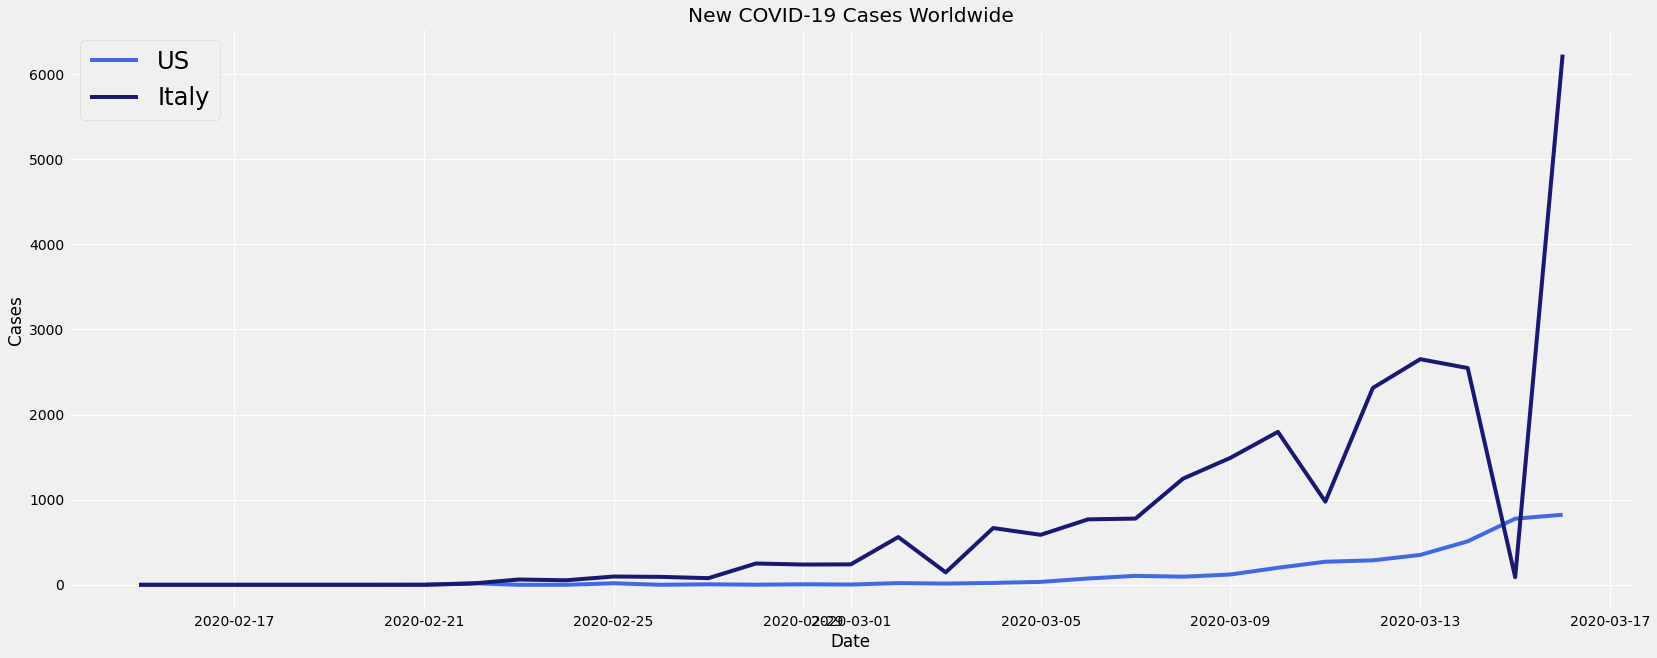

In [13]:
# plotting build of US vs. Italy cases
fig, ax = plt.subplots()
ax.plot(df_us['DATE_REP'], df_us['NEW_CASES'],color="royalblue")
ax.plot(df_itl['DATE_REP'], df_itl['NEW_CASES'],color="midnightblue")
ax.set(xlabel='Date', ylabel='Cases',
       title='New COVID-19 Cases Worldwide')
ax.legend(['US',"Italy"],fontsize = "xx-large", loc = "upper left")
ax.grid(color='white')